# 1分足データで、ある足からN足後に上昇する確率の分析

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as st
import statsmodels.stats.anova as anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale
from joblib import Parallel, delayed

import finalib as fl
import finalib.mine as mi
import ta

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

# データ読み込み

In [2]:
# 生データ
sp_dir = 'data/e-mini-sp500-200530'
df_sp_raw = pd.read_csv(f'{sp_dir}/e-mini-sp500-01min.csv')

# 月次データ（1年ごとの価格変化を見るため）
#df_spm_raw = pd.read_csv(f'{sp_dir}/e-mini-sp500-monthly.csv')

In [3]:
df_sp_raw

,Date,Time,Open,High,Low,Close,Up,Down
0,09/11/1997,04:34,1082.25,1082.25,1080.50,1080.50,4,0
1,09/11/1997,04:35,1079.75,1079.75,1079.75,1079.75,1,0
2,09/11/1997,05:46,1079.25,1079.25,1079.25,1079.25,1,0
3,09/11/1997,08:09,1078.75,1078.75,1078.75,1078.75,1,0
4,09/11/1997,08:10,1078.50,1078.50,1078.50,1078.50,2,0
...,...,...,...,...,...,...,...,...
6596587,05/29/2020,16:56,3056.00,3056.75,3055.75,3056.75,160,53
6596588,05/29/2020,16:57,3056.75,3057.25,3056.50,3057.25,135,98
6596589,05/29/2020,16:58,3057.00,3057.25,3056.50,3057.00,79,169
6596590,05/29/2020,16:59,3057.25,3057.50,3057.00,3057.00,160,155


# 分析用データ作成

In [4]:
# 年の列を追加
df_sp_raw['DT'] = (df_sp_raw['Date'] + '-' + df_sp_raw['Time']).map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y-%H:%M'))
df_sp_raw['year'] = df_sp_raw['DT'].map(lambda x: x.year)

# 年の順序づけ
min_year = df_sp_raw['year'].min()
max_year = df_sp_raw['year'].max()
year_type = CategoricalDtype(categories=[y for y in range(min_year, max_year+1)], ordered=True)
df_sp_raw['year'] = df_sp_raw['year'].astype(year_type)

In [27]:
df = df_sp_raw.copy()

# 何足分まで見れるようにするか
MAX_NBARS = 20
df = fl.make_nbars(df, MAX_NBARS, cols=['Close', 'Open'], datetime_col=None)

In [28]:
df.head()

,Date,Time,Open20,High,Low,Close20,Up,Down,DT,year,...,Close4,Open4,Close3,Open3,Close2,Open2,Close1,Open1,Close0,Open0
0,09/11/1997,04:34,1082.25,1082.25,1080.50,1080.50,4,0,1997-09-11 04:34:00,1997,...,1075.25,1075.25,1075.00,1074.75,1075.00,1075.25,1075.00,1075.00,1074.75,1074.75
1,09/11/1997,04:35,1079.75,1079.75,1079.75,1079.75,1,0,1997-09-11 04:35:00,1997,...,1075.00,1074.75,1075.00,1075.25,1075.00,1075.00,1074.75,1074.75,1073.75,1074.00
2,09/11/1997,05:46,1079.25,1079.25,1079.25,1079.25,1,0,1997-09-11 05:46:00,1997,...,1075.00,1075.25,1075.00,1075.00,1074.75,1074.75,1073.75,1074.00,1074.50,1074.00
3,09/11/1997,08:09,1078.75,1078.75,1078.75,1078.75,1,0,1997-09-11 08:09:00,1997,...,1075.00,1075.00,1074.75,1074.75,1073.75,1074.00,1074.50,1074.00,1075.00,1075.00
4,09/11/1997,08:10,1078.50,1078.50,1078.50,1078.50,2,0,1997-09-11 08:10:00,1997,...,1074.75,1074.75,1073.75,1074.00,1074.50,1074.00,1075.00,1075.00,1075.00,1075.00


# 全期間での上昇確率

In [29]:
for n in range(MAX_NBARS+1):
    df[f'CODiff{n}'] = df['Close0'] - df[f'Open{n}']
    df[f'isUp{n}'] = df[f'CODiff{n}'] > 0
    df[f'isFlat{n}'] = df[f'CODiff{n}'] == 0
    df[f'isDown{n}'] = df[f'CODiff{n}'] < 0

In [30]:
for n in range(MAX_NBARS+1):
    print(f'\n{n}足後の値動き傾向')
    print(f"P(UP) = {df[f'isUp{n}'].sum()} / {df.shape[0]} = {df[f'isUp{n}'].sum() / df.shape[0] * 100}%")
    print(f"P(FLAT) = {df[f'isFlat{n}'].sum()} / {df.shape[0]} = {df[f'isFlat{n}'].sum() / df.shape[0] * 100}%")
    print(f"P(DOWN) = {df[f'isDown{n}'].sum()} / {df.shape[0]} = {df[f'isDown{n}'].sum() / df.shape[0] * 100}%")


0日後の値動き傾向
P(UP) = 1996693 / 6596572 = 30.268645593499173%
P(FLAT) = 2609796 / 6596572 = 39.56291237327509%
P(DOWN) = 1990083 / 6596572 = 30.16844203322574%

1日後の値動き傾向
P(UP) = 2363718 / 6596572 = 35.83252028477821%
P(FLAT) = 1888796 / 6596572 = 28.632993015159997%
P(DOWN) = 2344058 / 6596572 = 35.53448670006179%

2日後の値動き傾向
P(UP) = 2506795 / 6596572 = 38.00148016272694%
P(FLAT) = 1609495 / 6596572 = 24.398960551025592%
P(DOWN) = 2480282 / 6596572 = 37.59955928624746%

3日後の値動き傾向
P(UP) = 2599332 / 6596572 = 39.40428452838838%
P(FLAT) = 1433123 / 6596572 = 21.72526882144241%
P(DOWN) = 2564117 / 6596572 = 38.870446650169214%

4日後の値動き傾向
P(UP) = 2665681 / 6596572 = 40.41009481894536%
P(FLAT) = 1305320 / 6596572 = 19.787853448730644%
P(DOWN) = 2625571 / 6596572 = 39.802051732324%

5日後の値動き傾向
P(UP) = 2716949 / 6596572 = 41.187286366312684%
P(FLAT) = 1208546 / 6596572 = 18.320818752527828%
P(DOWN) = 2671077 / 6596572 = 40.49189488115948%

6日後の値動き傾向
P(UP) = 2760215 / 6596572 = 41.843172484132666%


In [31]:
df_prob = pd.DataFrame(columns=['NBars', 'up', 'flat', 'down'])
for n in range(MAX_NBARS+1):
    p_up = df[f'isUp{n}'].sum() / df.shape[0] * 100
    p_flat = df[f'isFlat{n}'].sum() / df.shape[0] * 100
    p_down = df[f'isDown{n}'].sum() / df.shape[0] * 100
    df_prob = df_prob.append(pd.Series([n, p_up, p_flat, p_down], index=df_prob.columns), ignore_index=True)

df_prob

,NBars,up,flat,down
0,0.0,30.268646,39.562912,30.168442
1,1.0,35.832520,28.632993,35.534487
2,2.0,38.001480,24.398961,37.599559
3,3.0,39.404285,21.725269,38.870447
4,4.0,40.410095,19.787853,39.802052
5,5.0,41.187286,18.320819,40.491895
6,6.0,41.843172,17.101398,41.055430
7,7.0,42.377056,16.100969,41.521975
8,8.0,42.830231,15.263761,41.906008
9,9.0,43.241626,14.529274,42.229100


Text(0, 0.5, 'percentage (%)')

<Figure size 432x288 with 0 Axes>

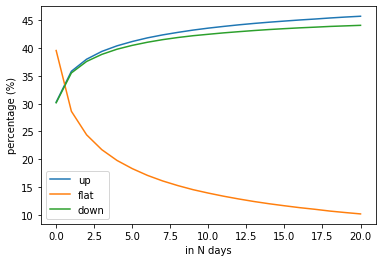

In [32]:
plt.figure()
df_prob[['up','flat','down']].plot()
plt.xlabel('in N days')
plt.ylabel('percentage (%)')